<a href="https://colab.research.google.com/github/JustBNM/graph-recommend-system/blob/main/Personalized_RecSys_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка и подключение библиотек

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 20.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 10.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 25.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 16.0 MB/s 
     |████████████████████████████████| 407 kB 22.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=e60ab21d5e4fc5ea3213f37af5c54da73390df4c4fea90c0257701f6f5f50667
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
!pip install umap
!pip install umap-learn

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=273b06c3a95175b0a59fe00d44f3eef37359ad51364251b3012a806997ab74ed
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 15.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5d2d89958258eefc5eaa7fea27f523ce9b580ce8eb2da7715ab1a85cd8553d1f
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=802e4a8fae506b48951c93eb07192831d6950b7ad15f119607b2fbd452e4451c
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from torch_cluster import random_walk

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler as RawNeighborSampler
from torch_geometric.nn import SAGEConv

import umap
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## Пример на заготовленном датасете

In [ ]:
dataset = 'Cora'
path = './data'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


Данные:
x - 2708 статей. Каждая статья кодируется наличием слов из словаря размером 1433
edge_index - связи статей по цитиремости. 105556 связей по индексам статей

# Хреначу свой пример

## Гетерограф

In [ ]:
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np

In [ ]:
number_of_person = 500
from scipy.special import softmax
genders = np.random.randint(0, 2, number_of_person)
# пиво берут редко
pivo_buy = np.random.choice([0,1], number_of_person, p=[0.8, 0.2])
# любовь к пиву зависит от того, взяли ли его
pivo_love = np.array([pivo*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - pivo)*np.random.normal(loc=0.3, scale=0.3, size=1) for pivo in pivo_buy]).squeeze()
# картошка с пивом - хорошо
kartoshka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.5, 0.4+2*pivo])) for pivo in pivo_love])
kartoshka_love = np.array([prod_buy*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - prod_buy)*np.random.normal(loc=0.4, scale=0.3, size=1) for prod_buy in kartoshka_buy]).squeeze()
# салатик берут девушки
salatic_love = np.array([gender*np.random.normal(loc=0.2, scale=0.2, size=1) + 
                      (1 - gender)*np.random.normal(loc=0.4, scale=0.2, size=1) for gender in genders]).squeeze()
salatic_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Пиво с мороженкой плохо заходит
morozenka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4-prod])) for prod in pivo_buy]).squeeze()
morozenka_love = 1/(0.5 + pivo_love)
cola_love = np.random.random(number_of_person)
burger_love = np.random.random(number_of_person)
# Если купил всего 1 продукт - пусть берёт колу
cola_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Если кроме колы ничего не взял - пусть берёт бургер

df_user = pd.DataFrame()
df_user['gender'] = genders
df_user['pivo_love'] = pivo_love
df_user['kartoshka_love'] = kartoshka_love
df_user['salatic_love'] = salatic_love
df_user['morozenka_love'] = morozenka_love
df_user['cola_love'] = salatic_love
df_user['burger_love'] = morozenka_love


df_user['pivo_buy'] = pivo_buy
df_user['kartoshka_buy'] = kartoshka_buy
df_user['salatic_buy'] = salatic_buy
df_user['morozenka_buy'] = morozenka_buy

cola_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) <= 1 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(cola_love)).squeeze()

df_user['cola_buy'] = cola_buy

burger_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) == 0 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(burger_love)).squeeze()
df_user['burger_buy'] = burger_buy

In [ ]:
df_user

,gender,pivo_love,kartoshka_love,salatic_love,morozenka_love,cola_love,burger_love,pivo_buy,kartoshka_buy,salatic_buy,morozenka_buy,cola_buy,burger_buy
0,0,0.128108,0.569941,0.524886,1.592082,0.524886,1.592082,0,0,1,0,1,1
1,1,0.072803,0.520588,0.260978,1.745800,0.260978,1.745800,0,1,1,1,1,1
2,1,0.542304,0.694345,0.171912,0.959413,0.171912,0.959413,1,0,1,0,0,1
3,0,0.803845,0.347575,0.326808,0.766963,0.326808,0.766963,0,1,1,0,0,0
4,1,-0.048842,0.595301,0.436912,2.216517,0.436912,2.216517,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0.659507,0.430852,-0.214684,0.862435,-0.214684,0.862435,0,1,0,1,0,1
496,0,0.462962,0.625231,0.320043,1.038462,0.320043,1.038462,0,0,0,1,1,1
497,0,0.951783,0.692444,0.418132,0.688808,0.418132,0.688808,1,1,1,0,1,0
498,0,0.059214,0.555961,0.463515,1.788223,0.463515,1.788223,0,1,1,1,1,0


In [ ]:
Counter(df_user.iloc[:, 7:].sum(axis=1))

Counter({2.0: 151, 3.0: 224, 4.0: 110, 5.0: 13, 6.0: 2})

In [ ]:
import sklearn.preprocessing as skl
category = ['Пиво','Картошка', 'Салатик', 'Мороженка', 'cola', 'burger']
df_dish = pd.DataFrame(np.eye(6), index = category)

In [ ]:
df_dish

,0,1,2,3,4,5
Пиво,1.0,0.0,0.0,0.0,0.0,0.0
Картошка,0.0,1.0,0.0,0.0,0.0,0.0
Салатик,0.0,0.0,1.0,0.0,0.0,0.0
Мороженка,0.0,0.0,0.0,1.0,0.0,0.0
cola,0.0,0.0,0.0,0.0,1.0,0.0
burger,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_user.iloc[:, :7].values

array([[ 0.        ,  0.12810823,  0.56994138, ...,  1.59208231,
         0.5248864 ,  1.59208231],
       [ 1.        ,  0.07280346,  0.52058843, ...,  1.7457995 ,
         0.26097812,  1.7457995 ],
       [ 1.        ,  0.5423039 ,  0.69434501, ...,  0.95941308,
         0.1719123 ,  0.95941308],
       ...,
       [ 0.        ,  0.95178314,  0.69244448, ...,  0.68880811,
         0.41813183,  0.68880811],
       [ 0.        ,  0.05921423,  0.55596133, ...,  1.78822344,
         0.46351495,  1.78822344],
       [ 1.        ,  0.66688237,  0.79944839, ...,  0.85698441,
        -0.14416688,  0.85698441]])

In [ ]:
df_user.iloc[:, 7:] = df_user.iloc[:, 7:].astype(int) 

In [ ]:
data = HeteroData()
data['user'].x = torch.from_numpy(df_user.iloc[:, 1:7].values)
data['dish'].x = torch.from_numpy(df_dish.values)
data['user'].y = torch.from_numpy(df_user.iloc[:, 7:].values)
#data['dish'].y = torch.from_numpy(df_dish.iloc[:, :6].values)

In [ ]:
data['dish']

{'x': tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)}

In [ ]:
torch_buy_pivo = torch.stack((torch.from_numpy(df_user[df_user.pivo_buy == 1].index.values) , 
                              torch.from_numpy(np.zeros(len(df_user[df_user.pivo_buy == 1].index))) ))

In [ ]:
torch_buy_kartoshka = torch.stack((torch.from_numpy(df_user[df_user.kartoshka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.kartoshka_buy == 1].index))) ))
torch_buy_salatic = torch.stack((torch.from_numpy(df_user[df_user.salatic_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.salatic_buy == 1].index))*2) ))
torch_buy_morozenka = torch.stack((torch.from_numpy(df_user[df_user.morozenka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.morozenka_buy == 1].index))*3) ))
torch_buy_cola = torch.stack((torch.from_numpy(df_user[df_user.cola_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.cola_buy == 1].index))*4) ))
torch_buy_burger = torch.stack((torch.from_numpy(df_user[df_user.burger_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.burger_buy == 1].index))*5) ))

In [ ]:
data['user', 'buys', 'dish'].edge_index = torch.cat((torch_buy_pivo, torch_buy_kartoshka, torch_buy_salatic,
                                                     torch_buy_morozenka, torch_buy_cola, torch_buy_burger), axis=1)

In [ ]:
#data['user', 'buys', 'dish'].edge_index = torch.stack((torch.from_numpy(user_nodes), torch.from_numpy(dish_nodes)))

In [ ]:
data['buys'].edge_index = data['buys'].edge_index.type(torch.LongTensor)

In [ ]:
data = T.ToUndirected()(data)

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
homogeneous_data = data.to_homogeneous()
homogeneous_data.x = homogeneous_data.x.float()

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={
    x=[6, 6],
    y=[6, 6]
  },
  (user, buys, dish)={ edge_index=[2, 1521] },
  (dish, rev_buys, user)={ edge_index=[2, 1521] }
)

In [ ]:
homogeneous_data

Data(node_type=[506], x=[506, 6], y=[506, 6], edge_index=[2, 3042], edge_type=[3042])

In [ ]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        # print(batch)
        # print(np.array(self.adj_t).shape)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]
        # print(pos_batch)

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)
        # print(neg_batch)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


In [ ]:
hetero_data = data

In [ ]:
hetero_data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
#data = homogeneous_data

In [ ]:
train_loader = NeighborSampler(data.edge_index, sizes=[1, 1], batch_size=1,
                               shuffle=True, num_nodes=data.num_nodes)

In [ ]:
from torch_geometric.loader import NeighborLoader
n_neigh = 1
loader = NeighborLoader(
    hetero_data,
    # Sample n_neigh neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [n_neigh] * 2 for key in hetero_data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=1,
    input_nodes=('user'),
)

In [ ]:
hetero_data.edge_types

[('user', 'buys', 'dish'), ('dish', 'rev_buys', 'user')]

In [ ]:
iterator = iter(loader)

In [ ]:
next(iterator)

HeteroData(
  user={
    x=[2, 6],
    y=[2, 6],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)

AttributeError: ignored

In [ ]:
model.train()

total_loss = 0
for batch_size, n_id, adjs in train_loader:
    # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
    adjs = [adj.to(device) for adj in adjs]
    optimizer.zero_grad()

    out = model(x[n_id], adjs)
    out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

    pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
    neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
    loss = -pos_loss - neg_loss
    loss.backward()
    optimizer.step()

    total_loss += float(loss) * out.size(0)
    #break

In [ ]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [ ]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
          #f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 3.9374, 
Epoch: 002, Loss: 1.9053, 
Epoch: 003, Loss: 2.5082, 
Epoch: 004, Loss: 1.2902, 
Epoch: 005, Loss: 1.6550, 
Epoch: 006, Loss: 1.3754, 
Epoch: 007, Loss: 1.0893, 
Epoch: 008, Loss: 1.1739, 
Epoch: 009, Loss: 1.1811, 
Epoch: 010, Loss: 12.5970, 
Epoch: 011, Loss: 1.8660, 
Epoch: 012, Loss: 1.4447, 
Epoch: 013, Loss: 1.2702, 
Epoch: 014, Loss: 1.2241, 
Epoch: 015, Loss: 1.1750, 
Epoch: 016, Loss: 1.2588, 
Epoch: 017, Loss: 1.2314, 
Epoch: 018, Loss: 1.5580, 
Epoch: 019, Loss: 1.2436, 
Epoch: 020, Loss: 1.6134, 
Epoch: 021, Loss: 1.4148, 
Epoch: 022, Loss: 1.3466, 
Epoch: 023, Loss: 1.3291, 
Epoch: 024, Loss: 1.7191, 
Epoch: 025, Loss: 1.3414, 
Epoch: 026, Loss: 1.2195, 
Epoch: 027, Loss: 1.1805, 
Epoch: 028, Loss: 1.3871, 
Epoch: 029, Loss: 1.2027, 
Epoch: 030, Loss: 1.2019, 
Epoch: 031, Loss: 1.1076, 
Epoch: 032, Loss: 1.1174, 
Epoch: 033, Loss: 1.2475, 
Epoch: 034, Loss: 1.9446, 
Epoch: 035, Loss: 1.4923, 
Epoch: 036, Loss: 1.3843, 
Epoch: 037, Loss: 1.7037, 


In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [ ]:
np.where(data.y[23].numpy() == 1)

(array([2, 4]),)

In [ ]:
for i in range(6):
  print(sum(data.y[:,i]))

tensor(109., dtype=torch.float64)
tensor(326., dtype=torch.float64)
tensor(260., dtype=torch.float64)
tensor(205., dtype=torch.float64)
tensor(349., dtype=torch.float64)
tensor(278., dtype=torch.float64)


In [ ]:
from numpy import linalg
for j in range(200):
  test = []
  for i in range(200, 206):
    test.append(sum(out[j].numpy() * out[i].numpy()))
  test = np.array(test)
  sorted_indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
  # print(sorted_indices)
  # print(np.where(data.y[j].numpy() == 1))
  # print('----')

In [ ]:
# palette = {}

# for n, y in enumerate(set(data.y.numpy())):
#     palette[y] = f'C{n}'

palette = {}

for n, y in enumerate(set(data.y[:,1].numpy())):
    palette[y] = f'C{n}'

In [ ]:
embd = umap.UMAP().fit_transform(out.cpu().numpy())

In [ ]:
sum(data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy())

46.0

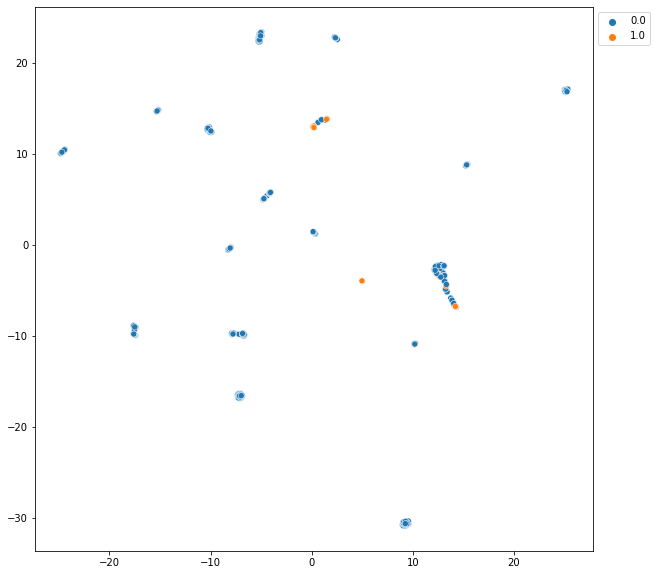

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.savefig("umap_embd_sage.png", dpi=120)

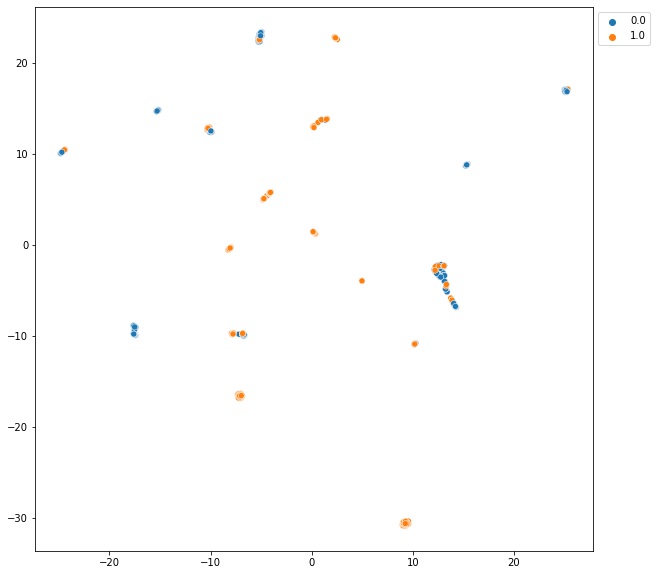

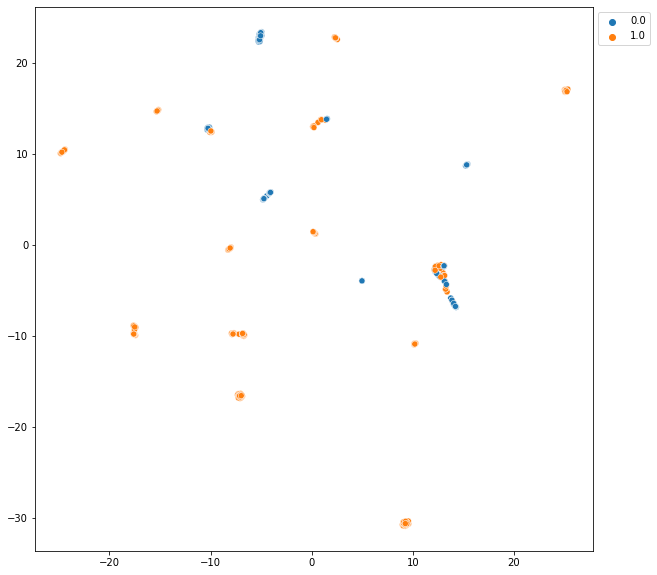

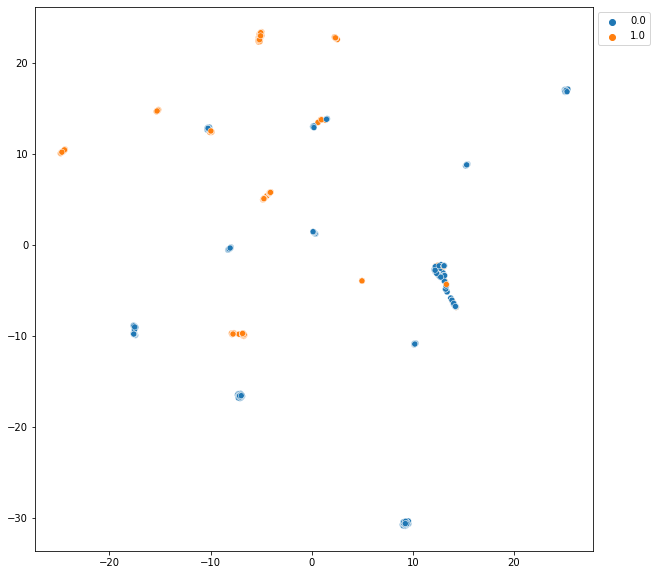

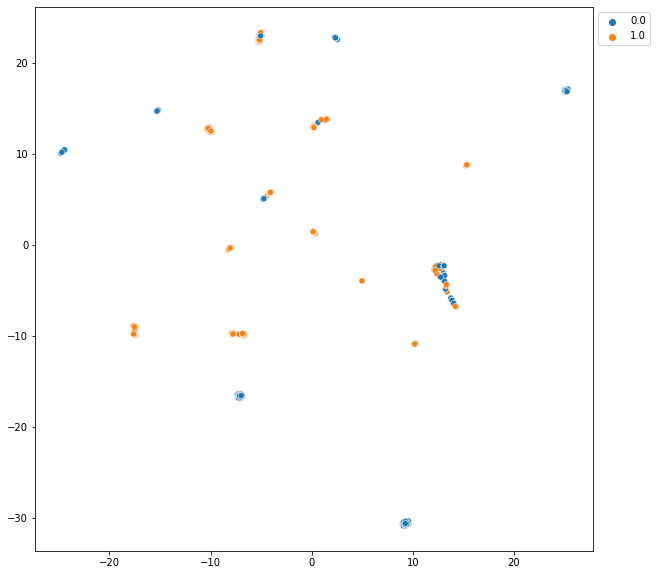

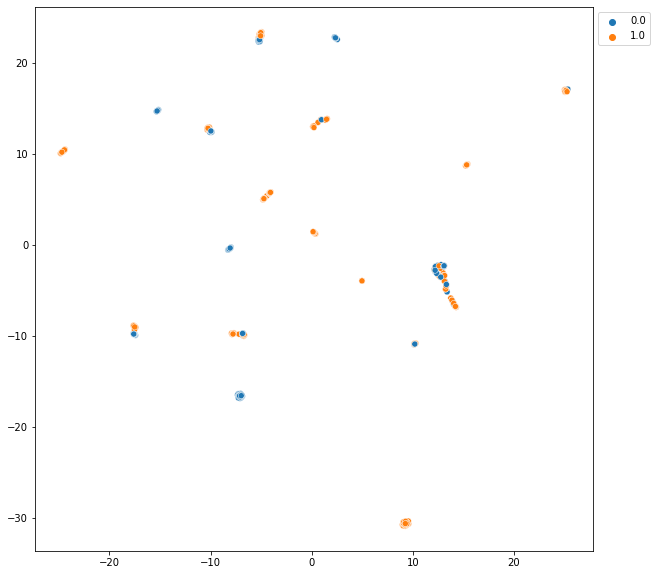

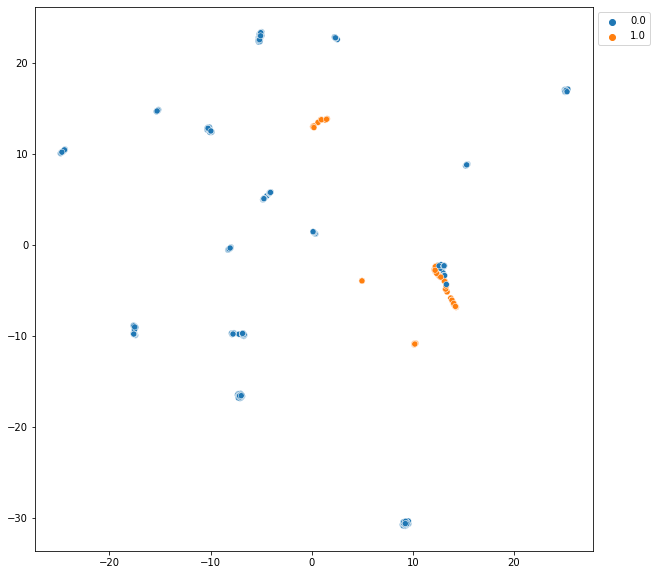

In [ ]:
for i in range(5,-1, -1):
  plt.figure(figsize=(10, 10))
  sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,i].cpu().numpy(), palette=palette)
  plt.legend(bbox_to_anchor=(1,1), loc='upper left')
  #plt.savefig("umap_embd_sage.png", dpi=120)

In [ ]:
embd_x = umap.UMAP().fit_transform(data.x.numpy())

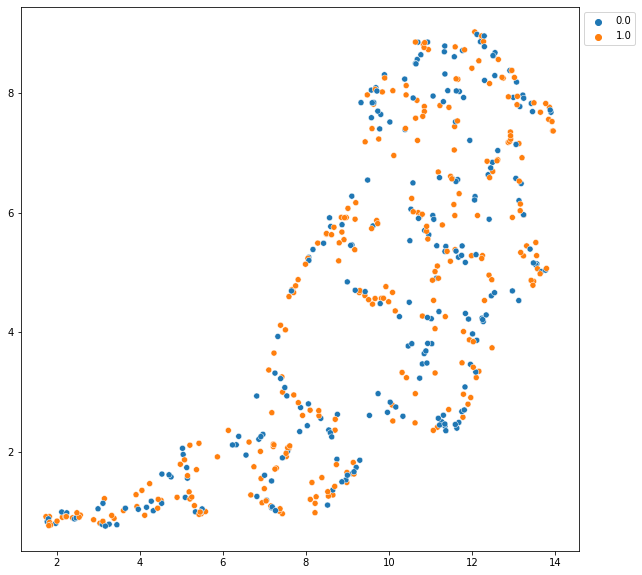

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y[:,5].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

## Запихиваю в  GNN

In [ ]:
from torch_geometric.loader import NeighborSampler as RawNeighborSampler
from torch_geometric.loader import NeighborLoader as RawNeighborLoader

In [ ]:
class NeighborLoader(RawNeighborLoader):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(RawNeighborLoader, self).sample(batch)

In [ ]:
#from torch_geometric.loader import NeighborLoader
N = 1
train_loader = NeighborLoader(
    data,
    # Sample N neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[N] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=1,
    input_nodes=('user'),
)

In [ ]:
iterator = iter(train_loader)
next(iterator)

HeteroData(
  user={
    x=[2, 7],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)

In [ ]:
test = next(iterator)
test

HeteroData(
  user={
    x=[2, 7],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)

In [ ]:
test['node_type']

tensor([0, 3, 0])

In [ ]:
for test in train_loader:
  print(test)
  print('-----')
  break

HeteroData(
  paper={
    x=[0, 128],
    year=[0],
    y=[0],
    train_mask=[0],
    val_mask=[0],
    test_mask=[0]
  },
  author={
    x=[1, 128],
    batch_size=1
  },
  institution={ x=[0, 128] },
  field_of_study={ x=[0, 128] },
  user={},
  (author, affiliated_with, institution)={ edge_index=[2, 0] },
  (author, writes, paper)={ edge_index=[2, 0] },
  (paper, cites, paper)={ edge_index=[2, 0] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 0] }
)
-----


In [ ]:
data

HeteroData(
  user={ x=[200, 7] },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 612] },
  (dish, rev_buys, user)={ edge_index=[2, 612] }
)

### Работа с визуализацией

In [ ]:
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

import torch_geometric
import networkx as nx

g = torch_geometric.utils.to_networkx(homogeneous_data, to_undirected=True)

Data(node_type=[206], x=[206, 7], edge_index=[2, 1240], edge_type=[1240])


In [ ]:
homogeneous_data.node_type

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1])

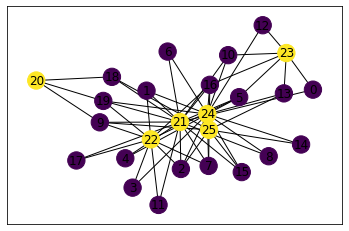

In [ ]:
nx.draw_networkx(g, node_color = homogeneous_data.node_type,)

In [ ]:
!pip install pygraphviz

  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165743 sha256=026599c27849b406bde8a4b6b463764d95114075cd66854595cfc0c8375282f2
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
!pip install dgl
import dgl

     |████████████████████████████████| 4.4 MB 7.8 MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
G = dgl.heterograph({
        ('user', 'buys', 'dish') : (np.array(data['buys'].edge_index[0]),np.array(data['buys'].edge_index[1]))
    })

print(G)

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])


In [ ]:
G

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])

In [ ]:
# Draw the metagraph using graphviz.
import pygraphviz as pgv

def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')

plot_graph(G.metagraph())

AttributeError: ignored

In [ ]:
class SAGE(nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
              self.convs.append(SAGEConv((-1, -1), hidden_channels))
            else:
              self.convs.append(SAGEConv(hidden_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


# dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
# data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data['user'].x.to(device), data['buys'].edge_index.to(device)

In [ ]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [ ]:
loss = train()

IndexError: ignored

### Работа с гетерографом

In [ ]:
from torch_geometric.data import HeteroData

data = HeteroData()

In [ ]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
data = dataset[0]

In [ ]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

работаю с author и institution

In [ ]:
data = HeteroData({'author': { 'x': data['author'].x },
              'institution': { 'x': data['institution'].x },
              ('author', 'affiliated_with', 'institution'): {'edge_index': data['affiliated_with'].edge_index }})

In [ ]:
data

HeteroData(
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] }
)

In [ ]:
from collections import Counter
stat = Counter(data['affiliated_with'].edge_index[0].numpy()).most_common()

In [ ]:
index_to_delete = np.array(stat)[np.array(stat)[:,1] == 1][:, 0]

In [ ]:
np.delete(np.array(data['author'].x), (index_to_delete)).shape

(144515482,)

(array([7.19590e+05, 1.00968e+05, 2.15380e+04, 6.43500e+03, 2.31800e+03,
        9.51000e+02, 3.69000e+02, 2.06000e+02, 1.11000e+02, 7.90000e+01,
        5.10000e+01, 3.60000e+01, 0.00000e+00, 2.40000e+01, 1.80000e+01,
        2.30000e+01, 1.90000e+01, 2.50000e+01, 2.00000e+01, 1.50000e+01,
        1.10000e+01, 1.10000e+01, 1.20000e+01, 8.00000e+00, 0.00000e+00,
        1.20000e+01, 1.10000e+01, 1.50000e+01, 8.00000e+00, 9.00000e+00,
        1.20000e+01, 9.00000e+00, 7.00000e+00, 1.00000e+01, 1.20000e+01,
        5.00000e+00, 1.20000e+01, 0.00000e+00, 6.00000e+00, 6.00000e+00,
        3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 1.  ,  1.92,  2.84,  3.76,  4.68,  5.6 ,  6.52,  7.44,  8.36,
         9.28, 10.2 , 11.12, 12.04, 12.96, 13.88, 14.8 , 15.72, 16.64,
        17.56, 18.48, 19.4 , 20.32, 21.24, 22.16, 23.08, 24.  , 24.92,
        25.84, 26.76, 27.68, 28.6 , 29.52, 30.44, 31.36

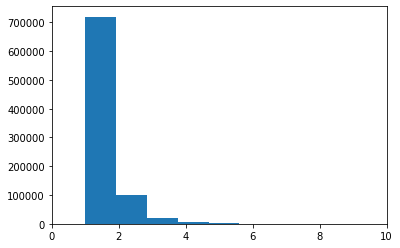

In [ ]:
import numpy as np
plt.xlim(0, 10)
plt.hist(np.array(stat)[:, 1], bins = 50)

In [ ]:
data = T.ToUndirected()(data)

In [ ]:
data.metadata()

(['author', 'institution'],
 [('author', 'affiliated_with', 'institution'),
  ('institution', 'rev_affiliated_with', 'author')])

In [ ]:
data.has_isolated_nodes()

True

In [ ]:
data.has_self_loops()

False

In [ ]:
data.is_undirected()

False

In [ ]:
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

Data(node_type=[206], edge_index=[2, 1224], edge_type=[1224])


In [ ]:
homogeneous_data.node_type

tensor([0, 0, 0, 1, 1, 1])

In [ ]:
np.array(homogeneous_data.edge_type)

array([0, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
data

HeteroData(
  user={ x=[3, 3] },
  dish={ x=[3, 2] },
  (user, buys, dish)={ edge_index=[2, 4] },
  (dish, rev_buys, user)={ edge_index=[2, 4] }
)

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader

#transform = T.ToUndirected()  # Add reverse edge types.
#data = OGB_MAG(root='./data', preprocess='metapath2vec', transform=transform)[0]

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=64,
    input_nodes=('author'),
)

batch = next(iter(train_loader))

In [ ]:
batch

HeteroData(
  paper={
    x=[0, 128],
    year=[0],
    y=[0],
    train_mask=[0],
    val_mask=[0],
    test_mask=[0]
  },
  author={
    x=[64, 128],
    batch_size=64
  },
  institution={ x=[0, 128] },
  field_of_study={ x=[0, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 0] },
  (author, writes, paper)={ edge_index=[2, 0] },
  (paper, cites, paper)={ edge_index=[2, 0] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 0] }
)

In [ ]:
data

HeteroData(
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (institution, rev_affiliated_with, author)={ edge_index=[2, 1043998] }
)